In [ ]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf

Daily Interactions with Media Type

In [ ]:
# Import and read int_w_media.csv

# URL of the CSV file
csv_url = "https://raw.githubusercontent.com/JulieKent/BootCamp_Final-Project4-ML/main/Resources/int_w_media.csv"

# Read the CSV file
daily_interactions_byMediaType_withdifot_df = pd.read_csv(csv_url, error_bad_lines=False)

# Display the first few rows of the DataFrame
daily_interactions_byMediaType_withdifot_df.head()

<ipython-input-60-0ceb18169586>:7: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  daily_interactions_byMediaType_withdifot_df = pd.read_csv(csv_url, error_bad_lines=False)


,intDate,mediaType,offerCount,Score
0,2022-12-01,voice,484,81.25
1,2022-12-01,email,937,81.25
2,2022-12-01,message,355,81.25
3,2022-12-01,callback,208,81.25
4,2022-12-02,voice,400,78.92


In [ ]:
# Create a new column 'Flag' using if statements

daily_interactions_byMediaType_withdifot_df['flag'] = (
    (daily_interactions_byMediaType_withdifot_df['offerCount'] > daily_interactions_byMediaType_withdifot_df['offerCount'].shift(1)) &
    (daily_interactions_byMediaType_withdifot_df['Score'] < daily_interactions_byMediaType_withdifot_df['Score'].shift(1))
).astype(int)

# Display the DataFrame with the new column
daily_interactions_byMediaType_withdifot_df

,intDate,mediaType,offerCount,Score,flag
0,2022-12-01,voice,484,81.25,0
1,2022-12-01,email,937,81.25,0
2,2022-12-01,message,355,81.25,0
3,2022-12-01,callback,208,81.25,0
4,2022-12-02,voice,400,78.92,1
...,...,...,...,...,...
973,2023-11-17,message,142,95.59,0
974,2023-11-20,callback,27,96.01,0
975,2023-11-20,email,1370,96.01,0
976,2023-11-20,message,174,96.01,0


In [ ]:
# Convert categorical data to numeric with `pd.get_dummies`
dummies = pd.get_dummies(daily_interactions_byMediaType_withdifot_df)
dummies.head()

,offerCount,Score,flag,intDate_2022-12-01,intDate_2022-12-02,intDate_2022-12-05,intDate_2022-12-06,intDate_2022-12-07,intDate_2022-12-08,intDate_2022-12-09,...,intDate_2023-11-13,intDate_2023-11-14,intDate_2023-11-15,intDate_2023-11-16,intDate_2023-11-17,intDate_2023-11-20,mediaType_callback,mediaType_email,mediaType_message,mediaType_voice
0,484,81.25,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,937,81.25,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,355,81.25,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,208,81.25,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,400,78.92,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Split our preprocessed data into our features and target arrays
y = dummies['flag'].values
X = dummies.drop(columns='flag').values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    # Allow kerastuner to decide number of neurons in first layer
    nn.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=252))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))

    nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn

In [ ]:
!pip install keras-tuner

In [ ]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

In [ ]:
# Get best 3 model hyperparameters
best_hyper = tuner.get_best_hyperparameters(3)
for param in best_hyper:
  print(param.values)

{'activation': 'sigmoid', 'first_units': 3, 'num_layers': 2, 'units_0': 7, 'units_1': 7, 'units_2': 5, 'units_3': 5, 'units_4': 3, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
{'activation': 'relu', 'first_units': 5, 'num_layers': 2, 'units_0': 7, 'units_1': 1, 'units_2': 3, 'units_3': 9, 'units_4': 3, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
{'activation': 'relu', 'first_units': 1, 'num_layers': 3, 'units_0': 7, 'units_1': 3, 'units_2': 9, 'units_3': 9, 'units_4': 9, 'tuner/epochs': 7, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


In [ ]:
# Evaluate best 3 models against full test data
best_model = tuner.get_best_models(3)
for model in best_model:
  model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
  print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 1s - loss: 0.6554 - accuracy: 0.9469 - 665ms/epoch - 83ms/step
Loss: 0.655362069606781, Accuracy: 0.9469387531280518
8/8 - 1s - loss: 0.4934 - accuracy: 0.9469 - 677ms/epoch - 85ms/step
Loss: 0.49343016743659973, Accuracy: 0.9469387531280518
8/8 - 1s - loss: 0.6830 - accuracy: 0.9469 - 516ms/epoch - 64ms/step
Loss: 0.6829590201377869, Accuracy: 0.9469387531280518


In [ ]:
# Creating model based on the top hyperparameter

nn = tf.keras.models.Sequential()

nn.add(tf.keras.layers.Dense(units=3, input_dim=252, activation="sigmoid"))
nn.add(tf.keras.layers.Dense(units=7, activation="sigmoid"))
nn.add(tf.keras.layers.Dense(units=7, activation="sigmoid"))
nn.add(tf.keras.layers.Dense(units=5, activation="sigmoid"))
nn.add(tf.keras.layers.Dense(units=5, activation="sigmoid"))
nn.add(tf.keras.layers.Dense(units=3, activation="sigmoid"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 3)                 759       
                                                                 
 dense_6 (Dense)             (None, 7)                 28        
                                                                 
 dense_7 (Dense)             (None, 7)                 56        
                                                                 
 dense_8 (Dense)             (None, 5)                 40        
                                                                 
 dense_9 (Dense)             (None, 5)                 30        
                                                                 
 dense_10 (Dense)            (None, 3)                 18        
                                                                 
 dense_11 (Dense)            (None, 1)                

In [ ]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=20)

Epoch 1/20
23/23 [==============================] - 2s 3ms/step - loss: 0.7694 - accuracy: 0.0573
Epoch 2/20
23/23 [==============================] - 0s 3ms/step - loss: 0.7344 - accuracy: 0.0573
Epoch 3/20
23/23 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.2769
Epoch 4/20
23/23 [==============================] - 0s 2ms/step - loss: 0.6684 - accuracy: 0.9427
Epoch 5/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.9427
Epoch 6/20
23/23 [==============================] - 0s 2ms/step - loss: 0.6078 - accuracy: 0.9427
Epoch 7/20
23/23 [==============================] - 0s 3ms/step - loss: 0.5797 - accuracy: 0.9427
Epoch 8/20
23/23 [==============================] - 0s 3ms/step - loss: 0.5531 - accuracy: 0.9427
Epoch 9/20
23/23 [==============================] - 0s 3ms/step - loss: 0.5281 - accuracy: 0.9427
Epoch 10/20
23/23 [==============================] - 0s 3ms/step - loss: 0.5045 - accuracy: 0.9427
Epoch 11/20
23/23 [

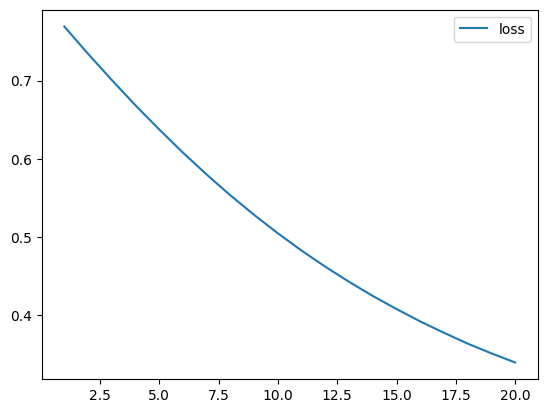

In [ ]:
import matplotlib.pyplot as plt
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

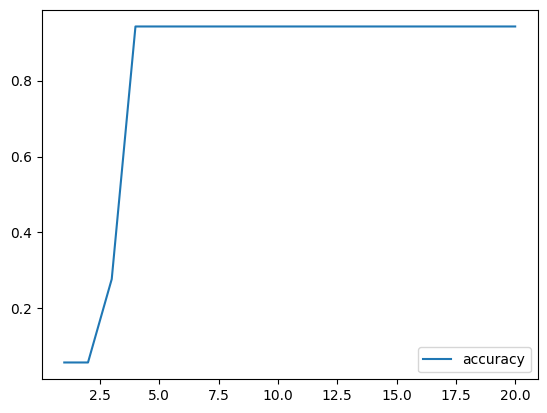

In [ ]:
# Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [ ]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 0.3282 - accuracy: 0.9469 - 176ms/epoch - 22ms/step
Loss: 0.3282470703125, Accuracy: 0.9469387531280518
